<a href="https://colab.research.google.com/github/akivig1601/Website-Phishing-Detection/blob/main/phishing_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📦 IMPORTS

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

📥 1. Load Dataset

In [6]:
from scipy.io import arff
data, meta = arff.loadarff('Training Dataset.arff')
df = pd.DataFrame(data).applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
df = df.apply(pd.to_numeric, errors='coerce').dropna()

🔍 2. EDA

Dataset shape: (11055, 31)
Result
 1    6157
-1    4898
Name: count, dtype: int64


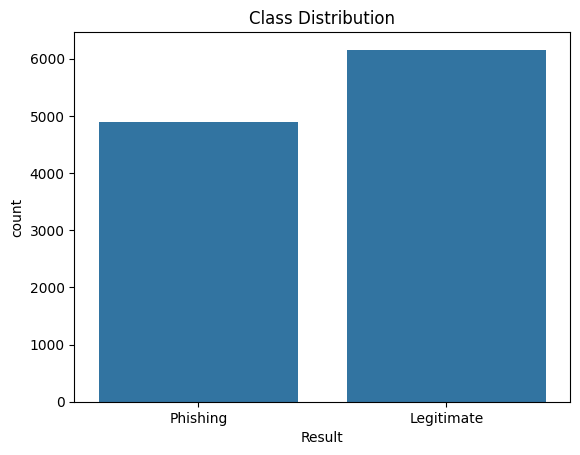

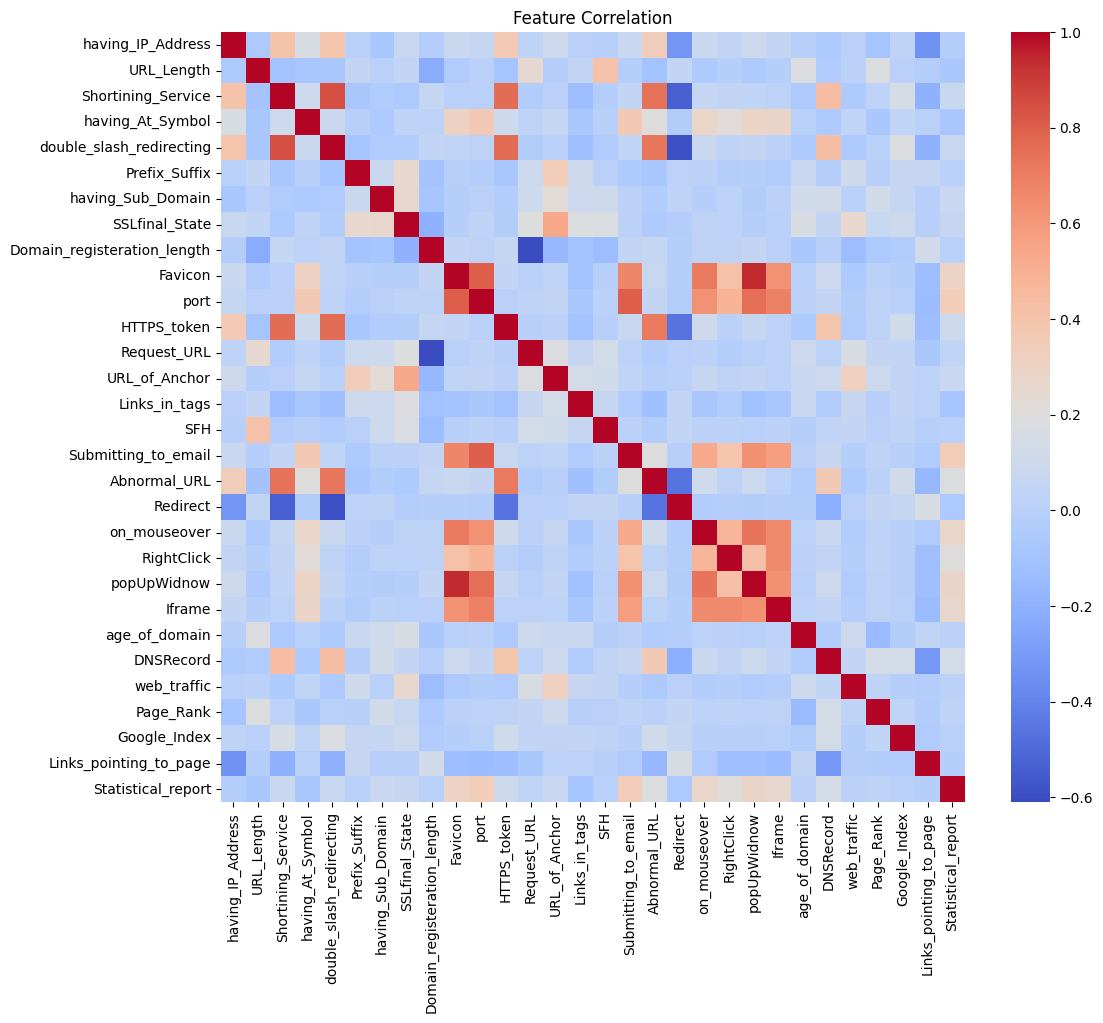

In [7]:
print("Dataset shape:", df.shape)
print(df["Result"].value_counts())

# Class distribution
sns.countplot(x=df["Result"].map({-1: 'Phishing', 1: 'Legitimate'}))
plt.title("Class Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.drop('Result', axis=1).corr(), cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

🔄 3. Preprocessing

In [8]:
X = df.drop(columns=["Result"])
y = df["Result"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

🤖 4. Model Definitions

In [9]:
models = {
    "Logistic Regression": Pipeline([
        ('scale', StandardScaler()),
        ('clf', LogisticRegression())
    ]),
    "Decision Tree": Pipeline([
        ('clf', DecisionTreeClassifier())
    ]),
    "Random Forest": Pipeline([
        ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
    ]),
    "SVM (RBF)": Pipeline([
        ('scale', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True))
    ]),
    "Gradient Boosting": Pipeline([
        ('clf', GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])
}

📊 5. Model Evaluation

In [10]:
results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps['clf'], 'predict_proba') else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": classification_report(y_test, y_pred, output_dict=True)["1"]["f1-score"],
        "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }

pd.DataFrame(results).T.sort_values("Accuracy", ascending=False)

,Accuracy,F1,ROC AUC
Random Forest,0.974220,0.976988,0.997795
Decision Tree,0.971054,0.974110,0.980452
Gradient Boosting,0.952962,0.957963,0.992078
SVM (RBF),0.951606,0.957251,0.989326
Logistic Regression,0.928539,0.936749,0.980802


🔍 6. Visuals: ROC Curve + Confusion Matrix for Best Model

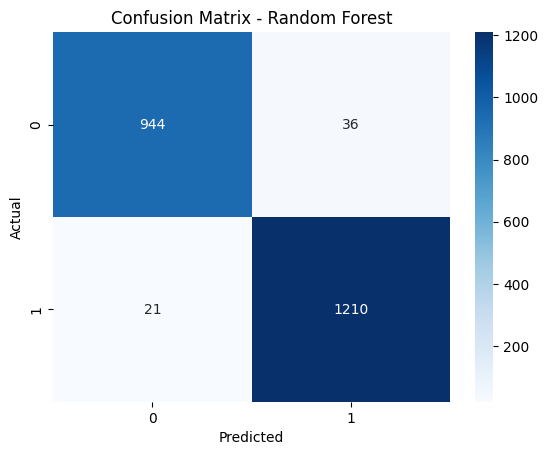

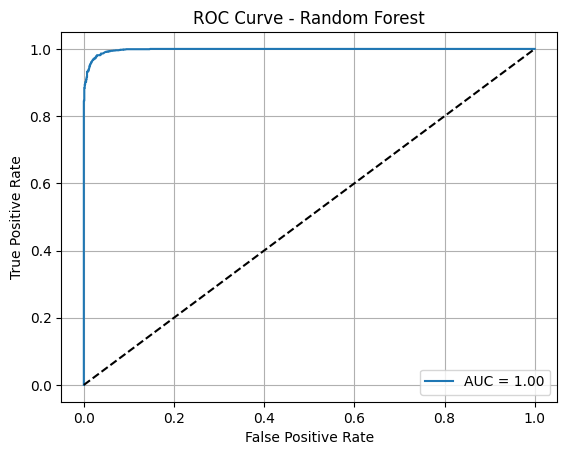

In [11]:
best_model = models["Random Forest"]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

⭐ 7. Feature Importance (RF)

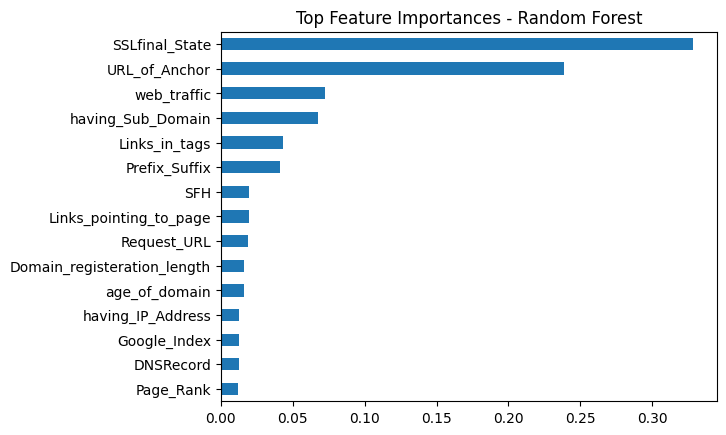

In [12]:
importances = best_model.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
feat_imp.head(15).plot(kind='barh')
plt.title("Top Feature Importances - Random Forest")
plt.gca().invert_yaxis()
plt.show()

8. 📊 SHAP Explainability

In [21]:
import shap

# Train the model (tree model only, no pipeline)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Use universal SHAP Explainer (recommended)
explainer = shap.Explainer(rf, X_train)

# Get full explanation for test set
shap_values = explainer(X_test)

# ✅ Local force plot for a single test sample
# Pick sample index
sample_idx = 0

# Extract values properly
base_value = shap_values[sample_idx].base_values
shap_contrib = shap_values[sample_idx].values
sample_features = shap_values[sample_idx].data

# Initialize JS for notebook
shap.initjs()

# ✅ Render force plot
shap.plots.force(base_value, shap_contrib, sample_features)


100%|===================| 4418/4422 [07:09<00:00]       

TypeError: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

🧠 9. Ensemble Model (Voting Classifier)

In [13]:
ensemble = VotingClassifier(estimators=[
    ('lr', models["Logistic Regression"]),
    ('rf', models["Random Forest"]),
    ('svc', models["SVM (RBF)"])
], voting='soft')

ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print("✅ Ensemble Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

✅ Ensemble Accuracy: 0.9579375848032564
              precision    recall  f1-score   support

          -1       0.97      0.94      0.95       980
           1       0.95      0.98      0.96      1231

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



🧪 Streamlit App for Phishing Detection

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier

st.set_page_config(page_title="Phishing Website Detector", layout="centered")

# Load the trained model
model = joblib.load("rf_model.pkl")  # Save your trained model with joblib first

st.title("🕵️ Phishing Website Detector")
st.markdown("Enter the feature values to predict if a site is phishing or legitimate.")

# Dynamically create inputs for all 30 features
feature_values = {}
features = [f"Feature_{i}" for i in range(1, 31)]  # Replace with actual feature names if available

for feat in features:
    feature_values[feat] = st.selectbox(f"{feat}:", [-1, 0, 1])

# Prediction button
if st.button("Predict"):
    input_df = pd.DataFrame([feature_values])
    prediction = model.predict(input_df)[0]
    label = "Legitimate ✅" if prediction == 1 else "Phishing ⚠️"
    st.success(f"Prediction: {label}")